# Wait for User Input

In [1]:
String userHomeDir = System.getProperty("user.home");
String localRespoUrl = "file://" + userHomeDir + "/.m2/repository/";
String langchain4jVersion = "1.0.0-beta1";
String langgraph4jVersion = "1.4-SNAPSHOT";

In [2]:
%dependency /add-repo local \{localRespoUrl} release|never snapshot|always
// %dependency /list-repos
%dependency /add org.bsc.langgraph4j:langgraph4j-core:\{langgraph4jVersion}
%dependency /add org.bsc.langgraph4j:langgraph4j-langchain4j:\{langgraph4jVersion}
%dependency /add dev.langchain4j:langchain4j:\{langchain4jVersion}
%dependency /add dev.langchain4j:langchain4j-open-ai:\{langchain4jVersion}
%dependency /add net.sourceforge.plantuml:plantuml-mit:1.2024.6
%dependency /list-dependencies
%dependency /resolve

Repository local url: file:///Users/bsorrentino/.m2/repository/ added.
Adding dependency org.bsc.langgraph4j:langgraph4j-core:1.3-SNAPSHOT
Adding dependency org.bsc.langgraph4j:langgraph4j-langchain4j:1.3-SNAPSHOT
Adding dependency dev.langchain4j:langchain4j:0.36.2
Adding dependency dev.langchain4j:langchain4j-open-ai:0.36.2
Adding dependency net.sourceforge.plantuml:plantuml-mit:1.2024.6
Proposed dependencies count: 5
 - org.bsc.langgraph4j:langgraph4j-core:jar:1.3-SNAPSHOT (runtime)
 - org.bsc.langgraph4j:langgraph4j-langchain4j:jar:1.3-SNAPSHOT (runtime)
 - dev.langchain4j:langchain4j:jar:0.36.2 (runtime)
 - dev.langchain4j:langchain4j-open-ai:jar:0.36.2 (runtime)
 - net.sourceforge.plantuml:plantuml-mit:jar:1.2024.6 (runtime)
Resolved dependencies count: 0
Solving dependencies
Resolved artifacts count: 26
Add to classpath: /Users/bsorrentino/Library/Jupyter/kernels/rapaio-jupyter-kernel/mima_cache/org/bsc/langgraph4j/langgraph4j-core/1.3-SNAPSHOT/langgraph4j-core-1.3-SNAPSHOT.jar


In [3]:
import net.sourceforge.plantuml.SourceStringReader;
import net.sourceforge.plantuml.FileFormatOption;
import net.sourceforge.plantuml.FileFormat;

static java.awt.Image plantUML2PNG( String code ) throws IOException { 
    var reader = new SourceStringReader(code);

    try(var imageOutStream = new java.io.ByteArrayOutputStream()) {

        var description = reader.outputImage( imageOutStream, 0, new FileFormatOption(FileFormat.PNG));

        var imageInStream = new java.io.ByteArrayInputStream(  imageOutStream.toByteArray() );

        return javax.imageio.ImageIO.read( imageInStream );

    }
}


SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


@startuml Graph_Diagram
skinparam usecaseFontSize 14
skinparam usecaseStereotypeFontSize 12
skinparam hexagonFontSize 14
skinparam hexagonStereotypeFontSize 12
title "Graph Diagram"
footer

powered by langgraph4j
end footer
circle start<<input>> as __START__
circle stop as __END__
usecase "step_1"<<Node>>
usecase "human_feedback"<<Node>>
usecase "step_3"<<Node>>
"__START__" -down-> "step_1"
"step_1" -down-> "human_feedback"
"human_feedback" -down-> "step_3"
"step_3" -down-> "__END__"
@enduml


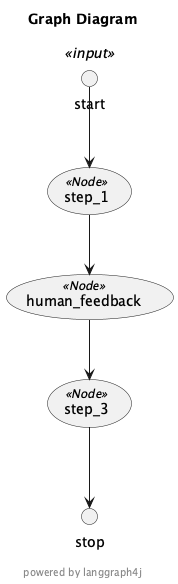

c1ce6176-a34b-4110-953e-0923f3918f51

In [4]:
import org.bsc.langgraph4j.*;
import org.bsc.langgraph4j.prebuilt.MessagesState;
import org.bsc.langgraph4j.state.Channel;
import org.bsc.langgraph4j.state.AppenderChannel;
import dev.langchain4j.data.message.AiMessage;
import dev.langchain4j.data.message.ChatMessage;
import org.bsc.langgraph4j.action.AsyncNodeAction;
import static org.bsc.langgraph4j.action.AsyncNodeAction.node_async;
import static org.bsc.langgraph4j.utils.CollectionsUtils.mapOf;
import org.bsc.langgraph4j.checkpoint.MemorySaver;
import org.bsc.langgraph4j.CompileConfig;
import static org.bsc.langgraph4j.StateGraph.END;
import static org.bsc.langgraph4j.StateGraph.START;

public class State extends MessagesState {

    public State(Map<String, Object> initData) {
        super( initData  );
    }

    Optional<String> input() { return value("input"); } 
    Optional<String> userFeedback() { return value("user_feedback"); } 

}

AsyncNodeAction<State> step1 = node_async(state -> {
    System.out.println( "---Step 1---" );
    return mapOf();
});

AsyncNodeAction<State> humanFeedback = node_async(state -> {
    System.out.println( "---human_feedback---" );
    return mapOf();
});

AsyncNodeAction<State> step3 = node_async(state -> {
    System.out.println( "---Step 3---" );
    return mapOf();
});

var builder = new StateGraph<>(State.SCHEMA, State::new);
builder.addNode("step_1", step1);
builder.addNode("human_feedback", humanFeedback);
builder.addNode("step_3", step3);
builder.addEdge(START, "step_1");
builder.addEdge("step_1", "human_feedback");
builder.addEdge("human_feedback", "step_3");
builder.addEdge("step_3", END);

// Set up memory
var saver = new MemorySaver();

// Add
var compileConfig = CompileConfig.builder().checkpointSaver(saver).interruptBefore("human_feedback").build();
var graph = builder.compile(compileConfig);

// View as PlantUML 
var plantuml = graph.getGraph(GraphRepresentation.Type.PLANTUML).getContent();

display( plantuml );
display( plantUML2PNG(plantuml) );

In [5]:
// Input
var initialInput = mapOf("input", (Object) "hello world");

// Thread
var invokeConfig = RunnableConfig.builder().threadId("Thread1").build();

// Run the graph until the first interruption
for (var event : graph.stream(initialInput, invokeConfig)) {
    System.out.println(event);
}


---Step 1---
NodeOutput{node=__START__, state={input=hello world, messages=[]}}
NodeOutput{node=step_1, state={input=hello world, messages=[]}}


In [6]:
// Get user input
//String userInput = new Scanner(System.in).nextLine();
String userInput = "go to step 3!";
System.out.println("Tell me how you want to update the state: " + userInput);

// We now update the state as if we are the human_feedback node
//var updateConfig = graph.updateState(invokeConfig, mapOf("user_feedback", userInput), "human_feedback");
var updateConfig = graph.updateState(invokeConfig, mapOf("user_feedback", userInput), null);

// We can check the state
System.out.println("--State after update--");
System.out.println(graph.getState(invokeConfig));

// We can check the next node, showing that it is node 3 (which follows human_feedback)
System.out.println("getNext with invokeConfig: " + graph.getState(invokeConfig).getNext());
System.out.println("getNext with updateConfig: " + graph.getState(updateConfig).getNext());

Tell me how you want to update the state: go to step 3!
--State after update--
StateSnapshot{node=step_1, state={user_feedback=go to step 3!, input=hello world, messages=[]}, config=RunnableConfig(threadId=Thread1, checkPointId=5a31577e-2b4a-4db8-a969-9a58dae4a080, nextNode=human_feedback, streamMode=VALUES)}
getNext with invokeConfig: human_feedback
getNext with updateConfig: human_feedback


In [7]:
// Continue the graph execution
for (var event : graph.stream(null, updateConfig)) {
    System.out.println(event);
}

---human_feedback---
---Step 3---
NodeOutput{node=human_feedback, state={user_feedback=go to step 3!, input=hello world, messages=[]}}
NodeOutput{node=step_3, state={user_feedback=go to step 3!, input=hello world, messages=[]}}
NodeOutput{node=__END__, state={user_feedback=go to step 3!, input=hello world, messages=[]}}


In [8]:
graph.getState(updateConfig).getState();

{user_feedback=go to step 3!, input=hello world, messages=[]}